In [37]:
# !pip install spec2nii

In [38]:
import numpy as np
import nibabel as nib
import subprocess
import os

In [53]:
# specify where the raw dicoms are located

path_to_dcm_pre = "/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/ADLER/ACTIVE/mrs-svs_task-pre/sub-ADLER_ses-ACTIVE_acq-mrs-svs_task-pre"

path_to_dcm_post = "/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/ADLER/ACTIVE/mrs-svs_task-post/sub-ADLER_ses-ACTIVE_acq-mrs-svs_task-post"

# examine the contents of path_to_dcm_pre
os.listdir(path_to_dcm_pre), os.listdir(path_to_dcm_post)


(['1.3.12.2.1107.5.2.43.166037.2024081215253773011767027.MR.dcm',
  '1.3.12.2.1107.5.2.43.166037.2024081215253773349167030.MR.dcm',
  '1.3.12.2.1107.5.2.43.166037.2024081215253773018767029.MR.dcm'],
 ['1.3.12.2.1107.5.2.43.166037.2024081215455933140064043.MR.dcm',
  '1.3.12.2.1107.5.2.43.166037.2024081215455932761764040.MR.dcm',
  '1.3.12.2.1107.5.2.43.166037.2024081215455932768564042.MR.dcm'])

In [58]:
# specify where we would like the niftis to be written to
path_to_output_nii_pre = '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/tmp/tmp_pre'
path_to_output_nii_post = '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/tmp/tmp_post'

In [59]:
# convert dicoms to nifti
subprocess.run(["spec2nii", "dicom", "-f", path_to_output_nii_pre, path_to_dcm_pre])
subprocess.run(["spec2nii", "dicom", "-f", path_to_output_nii_post, path_to_dcm_post])

/Users/jacekdmochowski/fsl/lib/python3.10/site-packages/spec2nii/Siemens/dicomfunctions.py:10: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  import nibabel.nicom.dicomwrappers


Found 3 files.


/Users/jacekdmochowski/fsl/lib/python3.10/site-packages/spec2nii/Siemens/dicomfunctions.py:10: UserWarning: The DICOM readers are highly experimental, unstable, and only work for Siemens time-series at the moment
Please use with caution.  We would be grateful for your help in improving them
  import nibabel.nicom.dicomwrappers


Found 3 files.


CompletedProcess(args=['spec2nii', 'dicom', '-f', '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/tmp/tmp_post', '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_flywheel/jacek/FUSRelabeledCopy/ADLER/ACTIVE/mrs-svs_task-post/sub-ADLER_ses-ACTIVE_acq-mrs-svs_task-post'], returncode=0)

## EMILY: you don't need to go past this step

In [ ]:
# Guess who's back, back again, Jacek's back, tell a friend

## Here I am reading in the nifti file from spec2nii

In [60]:
#
path_to_nii = '/Users/jacekdmochowski/PROJECTS/fus/data/mrs_working/tmp/tmp_pre.nii.gz'
nii = nib.load(path_to_nii)

In [61]:
nii.shape

(1, 1, 1, 512, 3)

## Here I am reading in the contents of the nifti file

In [62]:
# get the data and keep complex numbers
data = nii.get_fdata(dtype=np.complex64)

In [63]:
data = np.squeeze(data)
data.shape

(512, 3)

/Users/jacekdmochowski/miniconda3/envs/fus/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/jacekdmochowski/miniconda3/envs/fus/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


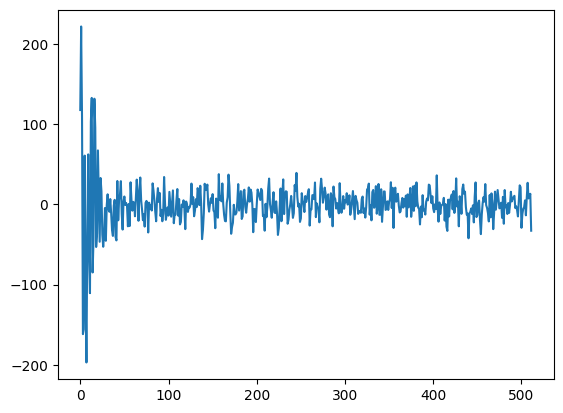

In [64]:
# plot power spectrum
import matplotlib.pyplot as plt
plt.plot(data[:,2])
#plt.xlim([0,100])

In [65]:
fid = data[:,2]
power = np.abs(np.fft.fft(fid))**2

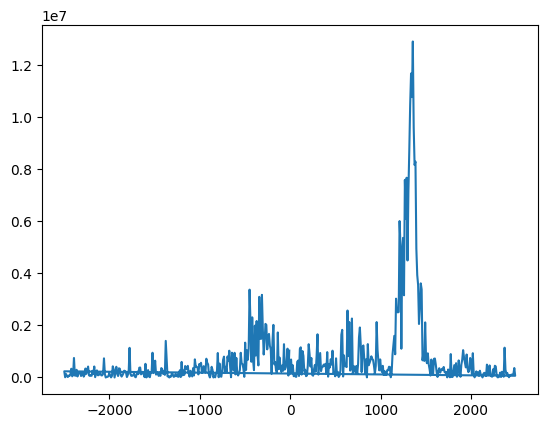

In [66]:
# plot power spectrum
import matplotlib.pyplot as plt
freqs = np.fft.fftfreq(len(fid),1/5000)
plt.plot(freqs,power)
#plt.xlim([0,3000])

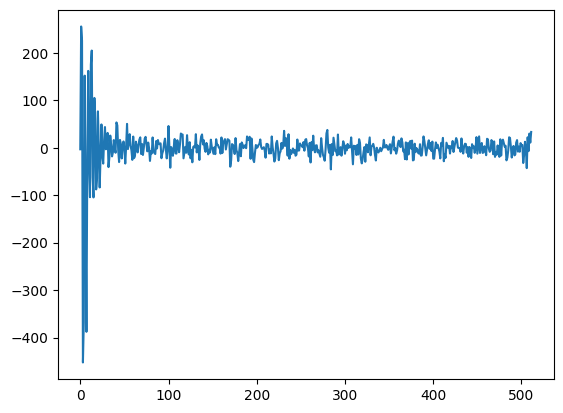

In [9]:
# plot the spectrum
import matplotlib.pyplot as plt

In [7]:
import numpy as np
data = np.squeeze(data)


In [8]:
data.shape

(2048,)

In [9]:
# perform fft
data_fft = np.fft.fft(data)

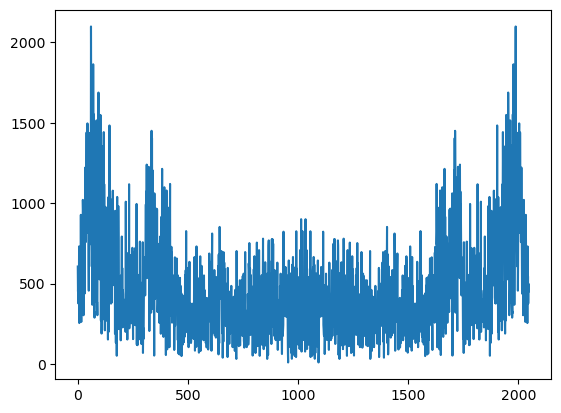

In [11]:
# plot magnitude
plt.plot(np.abs(data_fft))